In [11]:
import itertools

import utils
from PolishSystem.OperatorsBasedOnSimilarities.get_operators import get_operators_for_similarities
import os
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import gian_get_similarities
from PolishSystem.GlobalPSPolishSearch import find_ps_in_polish_problem
from initial_testing.rearrange_linkage_table import clean_table
from PolishSystem.read_data import get_pRef_from_vectors, get_vectors_file_name, get_fitness_file_name
from Core.PS import PS, STAR
from SimplifiedSystem.ps_search_utils import get_metric_function
from Core.PSMetric.Simplicity import Simplicity
import numpy as np


# this section will generate the search objectives
size = 100
method = "qmc"
fitness_column_to_use = 2
data_folder = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting"

pRef = get_pRef_from_vectors(get_vectors_file_name(data_folder, size, method), 
                                     get_fitness_file_name(data_folder, size, method), fitness_column_to_use)
best_solution = pRef.get_best_solution()

simplicity = get_metric_function("simplicity")
sample_size = get_metric_function("sample_count", pRef=pRef)
variance = get_metric_function("variance", pRef=pRef)
mean_fitness = get_metric_function("mean_fitness", pRef=pRef)
consistency = get_metric_function("consistency/greater", pRef=pRef)

cluster_info_file_name = os.path.join(data_folder, f"cluster_info_{size}_qmc.pkl")
similarities = gian_get_similarities(cluster_info_file_name)

sampler, mutation, crossover= get_operators_for_similarities(similarities, pRef, wanted_average_quantity_of_ones=2)


def make_cached_metric(original_metric):
    cached_values = dict()
    
    def get_value(ps):
        if ps in cached_values:
            return cached_values[ps]
        else:
            value = original_metric(ps)
            cached_values[ps] = value
            return value
    return get_value


def atomicity_on_similarity(ps):
    if ps.fixed_count() < 2:
        return 1000
    else:
        valid_indices = [index for index, value in enumerate(ps.values) if value != STAR]
        linkages = [similarities[a, b] for a, b in itertools.combinations(valid_indices, r=2)]
        return -np.average(linkages)
    
    


pss = find_ps_in_polish_problem(original_problem_search_space=pRef.search_space,
                          objectives=[make_cached_metric(sample_size), make_cached_metric(consistency), make_cached_metric(atomicity_on_similarity)],
                          ps_budget=10000,
                          population_size=60,
                          sampling_operator=sampler,
                          mutation_operator=mutation,
                          crossover_operator=crossover,
                          culling_method=None,
                          verbose=True,
                          )



n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       50 |     14 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      110 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0083682141 |             f
     3 |      170 |     14 |  0.000000E+00 |  0.000000E+00 |  0.0164246937 |             f
     4 |      230 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0031388125 |             f
     5 |      290 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0072591802 |             f
     6 |      350 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0346640031 |             f
     7 |      410 |     14 |  0.000000E+00 |  0.000000E+00 |  0.0565299772 |             f
     8 |      470 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0286316376 |             f
     9 |      530 |     10 |  0.000000E+00 |  0.000000E+00 |  0.1220422881 |         nadir
    10 |      590 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0113159870 |             f

The overall mean is 3.534054927435413
[7, 48, 64, 80, 86, 92] sample_size = 163.0, p_value = 0.031, atomicity = 0.01
[29, 64, 86, 92] sample_size = 151.0, p_value = 0.032, atomicity = 0.08
[60, 64, 86, 92] sample_size = 150.0, p_value = 0.023, atomicity = 0.05
[29, 48, 64, 86] sample_size = 146.0, p_value = 0.014, atomicity = 0.01
[29, 48, 64, 86, 92] sample_size = 138.0, p_value = 0.011, atomicity = 0.02
[29, 64, 80, 86] sample_size = 135.0, p_value = 0.005, atomicity = 0.00
[60, 64, 80, 86] sample_size = 135.0, p_value = 0.017, atomicity = 0.02
[29, 64, 80, 86, 92] sample_size = 125.0, p_value = 0.002, atomicity = 0.04
[29, 60, 64, 86] sample_size = 103.0, p_value = 0.013, atomicity = 0.07
[64, 71, 80, 86, 92] sample_size = 95.0, p_value = 0.007, atomicity = 0.06
[10, 29, 60, 64, 86] sample_size = 90.0, p_value = 0.021, atomicity = 0.08
[10, 29, 60, 64, 81, 86] sample_size = 86.0, p_value = 0.036, atomicity = 0.09
[29, 64, 71, 86] sample_size = 83.0, p_value = 0.006, atomicity = 0.06

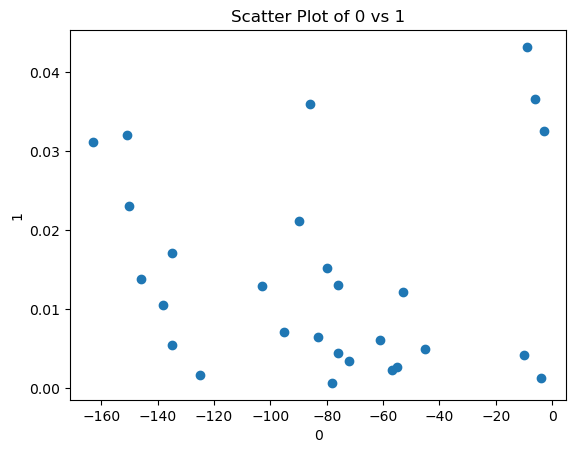

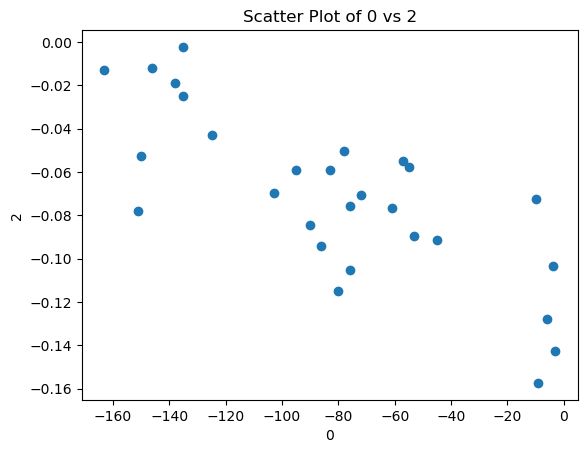

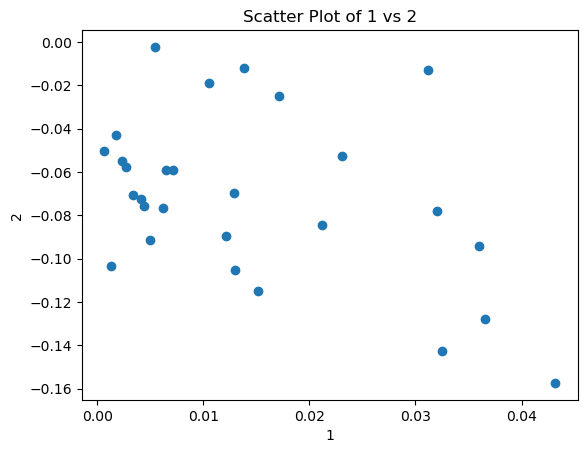

In [9]:
from Core.PSMetric.FitnessQuality.SignificantlyHighAverage import MannWhitneyU
from Core.EvaluatedPS import EvaluatedPS

universality_threshold = pRef.sample_size // 100

def is_good_ps(ps: EvaluatedPS, verbose=False) -> bool:
    non_trivial = ps.fixed_count() > 1
    enough_samples = (-sample_size(ps)) > universality_threshold
    provably_good = consistency(ps) < 0.05
    positive_atomicity = atomicity_on_similarity(ps) < 0  # since it's negated
    if verbose:
        if not non_trivial:
            print(f"The ps is nearly trivial, {ps.fixed_count() = }")
        if not enough_samples:
            print(f"The ps does not have enough samples, {-sample_size(ps) =}")
        if not provably_good:
            print(f"The ps is not provably good, consistency = {consistency(ps) = }")
        if not positive_atomicity:
            print(f"The ps does not have positive atomicity, {-atomicity_on_similarity(ps) = }")
    return non_trivial  and provably_good and positive_atomicity

mean_overall = pRef.cached_mean
print(f"The overall mean is {mean_overall}")
pss_to_show = list(set(pss))
pss_to_show = [ps for ps in pss_to_show 
              if is_good_ps(ps)]

pss_to_show.sort(key=lambda x: x.metric_scores[0])

def get_indices(ps):
    return [index for index, value in enumerate(ps.values) if value != -1]

for ps in pss_to_show:
    sample_size = -ps.metric_scores[0]
    p_value = ps.metric_scores[1]
    atomicity = -ps.metric_scores[2]
    print(get_indices(ps), f"{sample_size = }, {p_value = :.3f}, {atomicity = :.2f}")


def plot_for_dims(x_dim, y_dim):
    utils.simple_scatterplot(x_label = f"{x_dim}",
                             y_label=f"{y_dim}",
                             xs = [ps.metric_scores[x_dim] for ps in pss_to_show],
                             ys = [ps.metric_scores[y_dim] for ps in pss_to_show],
                             )
    
for x_dim, y_dim in itertools.combinations(range(3), r=2):
    plot_for_dims(x_dim, y_dim)

In [3]:
merged_ps = PS.empty(pRef.search_space)
for ps in pss_to_show:
    merged_ps = PS.merge(ps, merged_ps)
    is_good_ps(ps, verbose=True)

print(get_indices(merged_ps))


is_good_ps(merged_ps, verbose=True)

The ps does not have enough samples, -sample_size(ps) =163
The ps does not have enough samples, -sample_size(ps) =151
The ps does not have enough samples, -sample_size(ps) =150
The ps does not have enough samples, -sample_size(ps) =146
The ps does not have enough samples, -sample_size(ps) =138
The ps does not have enough samples, -sample_size(ps) =135
The ps does not have enough samples, -sample_size(ps) =135
The ps does not have enough samples, -sample_size(ps) =125
The ps does not have enough samples, -sample_size(ps) =103
The ps does not have enough samples, -sample_size(ps) =95
The ps does not have enough samples, -sample_size(ps) =90
The ps does not have enough samples, -sample_size(ps) =86
The ps does not have enough samples, -sample_size(ps) =83
The ps does not have enough samples, -sample_size(ps) =80
The ps does not have enough samples, -sample_size(ps) =78
The ps does not have enough samples, -sample_size(ps) =76
The ps does not have enough samples, -sample_size(ps) =76
The p

False

In [4]:
import numpy as np


class Dummy:
    n_var: int
    def __init__(self):
        self.n_var = size

def print_as_pss(ps_matrix):
    pss = [PS(row) for row in ps_matrix]
    all_values_present = set(value for row in ps_matrix for value in row)
    average_value = np.average(ps_matrix)
    average_order = np.average(np.sum(pRef.full_solution_matrix, axis=1))
    
    print(f"{average_order = :.2f}")
    print(f"{average_value = :.2f}")
    print(f"{all_values_present = }")
    for ps in pss:
        print(ps)
    

sampled_rows = sampler._do(Dummy(), 30)
print_as_pss(sampled_rows)



average_order = 6.14
average_value = 0.02
all_values_present = {False, True}
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [5]:
mutated_rows = mutation._do(None, sampled_rows)
print_as_pss(mutated_rows)

average_order = 6.14
average_value = 1.00
all_values_present = {False, True}
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [6]:
to_cross = np.array([sampled_rows, mutated_rows])
crossed = crossover._do(Dummy(), X=to_cross)
print(crossed.shape)
print_as_pss(crossed[0])

(2, 30, 100)
average_order = 6.14
average_value = 0.51
all_values_present = {False, True}
[0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1]
[1 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 1 1 0 0 0 1 1 1 0]
[1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 0 1 0]
[1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0]
[1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1

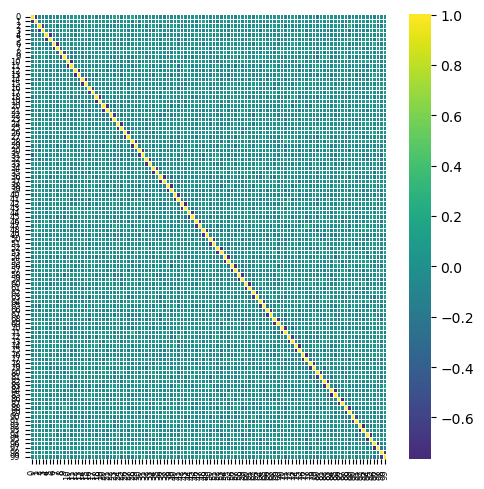

In [7]:
import utils

utils.show_matrix_with_colours(similarities, fig_size=(5, 5))
